# Causal Inference for Marketing Strategy

**Author:** Peter Osipchuk
**Date:** August 2025

## Project Goal
This notebook investigates the true causal impact of a marketing campaign on customer claim amounts using the IBM Watson Marketing Dataset. The goal is to move beyond a simple correlational analysis, which can be misleading due to selection bias, and use Propensity Score Matching (PSM) to estimate a more reliable measure of the campaign's effectiveness and ROI.

## Key Findings
* A naive comparison showed a negligible **+$14.00** difference in claim amounts.
* Causal analysis revealed a statistically insignificant effect of **-$4.83** on the target audience (ATT), suggesting the campaign was ineffective in its current form.
* However, the model uncovered a significant potential effect of **-$20.23** on the broader population (ATE), indicating a major **targeting mismatch**.

## 1. Data Preparation and Cleaning

### 1.1. Load Libraries and Data

In [ ]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from causalinference import CausalModel

pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Define the file path
file_path = '../data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv'

# Load the CSV into a pandas DataFrame
df = pd.read_csv(file_path)

### 1.2. Initial Data Inspection

In [3]:
# Display the first 5 rows of the DataFrame
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [4]:
# Get a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
# Get the number of rows and columns
df.shape

(9134, 24)

In [6]:
# Get the column names
df.columns

Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [7]:
# Get summary statistics for numerical columns
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


### 1.3. Standardize Column Names

In [8]:
# Create a copy of the original dataframe to work with
df_clean = df.copy()

# Function to standardize column names
def standardize_columns(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.lower().replace(' ', '_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Apply the function to our dataframe
df_clean = standardize_columns(df_clean)

# Verify the changes by checking the new column names
print("New column names:")
print(df_clean.columns)

New column names:
Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size'],
      dtype='object')


In [9]:
# Specify the date format to remove the warning and ensure correct parsing
df_clean['effective_to_date'] = pd.to_datetime(df_clean['effective_to_date'], format='%m/%d/%y')

# Verify the change by checking the dtypes again
print("Data types after conversion:")
df_clean.info()

Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer                       9134 non-null   object        
 1   state                          9134 non-null   object        
 2   customer_lifetime_value        9134 non-null   float64       
 3   response                       9134 non-null   object        
 4   coverage                       9134 non-null   object        
 5   education                      9134 non-null   object        
 6   effective_to_date              9134 non-null   datetime64[ns]
 7   employmentstatus               9134 non-null   object        
 8   gender                         9134 non-null   object        
 9   income                         9134 non-null   int64         
 10  location_code                  9134 non-null   object  

### Framing the Causal Inference Problem

Our primary goal is to determine the causal effect of a marketing campaign on customer value. The dataset description doesn't explicitly state which marketing offer is "the campaign," but we can frame it by analyzing the customer `response`.

We will define our problem as follows:

* **Treatment (T):** Did the customer respond to a marketing offer? The `response` column contains 'Yes' or 'No'. We will consider `response = 'Yes'` as the **treatment group** (they received the treatment and it was effective) and `response = 'No'` as the **control group**.
* **Outcome (Y):** What is the metric we are trying to influence? We want to measure the impact on customer value. The `total_claim_amount` is a perfect candidate for this. It's a direct measure of the cost/value a customer represents.
* **Confounders (W):** What pre-existing customer characteristics might influence *both* their likelihood to respond to an offer AND their total claim amount? These are the variables we need to control for. Potential confounders include:
    * `income`
    * `customer_lifetime_value`
    * `marital_status`
    * `education`
    * `employmentstatus`
    * And many others.

## 2. Exploratory Data Analysis (EDA)

In [10]:
# Create the binary treatment variable 'treatment'
# 1 if customer responded ('Yes'), 0 if they did not ('No')
df_clean['treatment'] = df_clean['response'].apply(lambda x: 1 if x == 'Yes' else 0)

# The outcome variable is already numerical
# Let's assign it to a clearly named variable for clarity, though we can also use the column name
outcome = 'total_claim_amount'

# Display the first few rows with the new 'treatment' column to verify
df_clean[['response', 'treatment', 'total_claim_amount']].head()

,response,treatment,total_claim_amount
0,No,0,384.811147
1,No,0,1131.464935
2,No,0,566.472247
3,No,0,529.881344
4,No,0,138.130879


# Phase 3: Exploratory Data Analysis (EDA)

In this phase, we will visually explore the cleaned dataset to uncover patterns, understand the distribution of our data, and set the stage for our causal analysis.

## Part A: Univariate Analysis

We'll start by analyzing our key variables one at a time: the outcome (`total_claim_amount`) and the treatment (`response`).

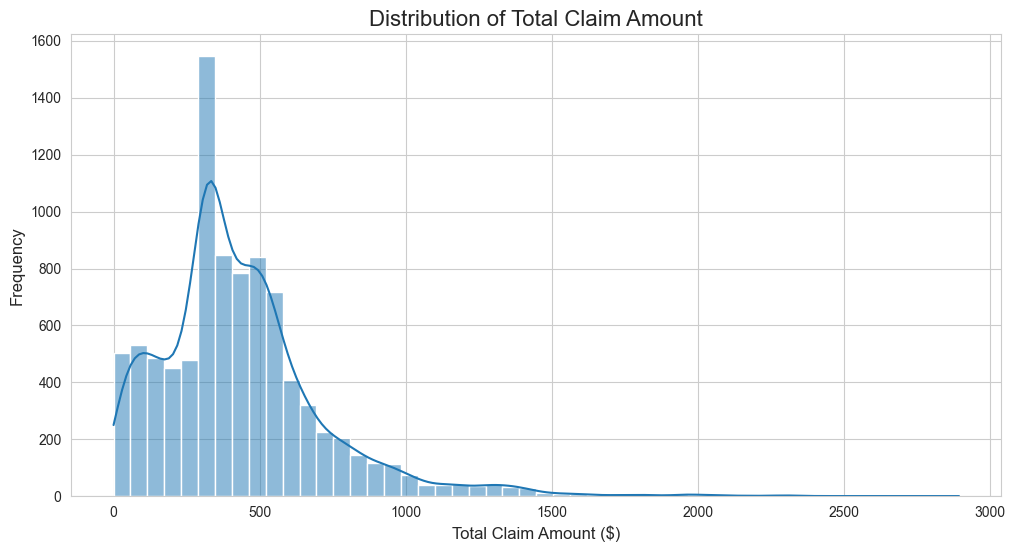

In [11]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create a figure and axes for the plot
plt.figure(figsize=(12, 6))

# Plot a histogram with a Kernel Density Estimate
sns.histplot(df_clean['total_claim_amount'], kde=True, bins=50)

# Add titles and labels for clarity
plt.title('Distribution of Total Claim Amount', fontsize=16)
plt.xlabel('Total Claim Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

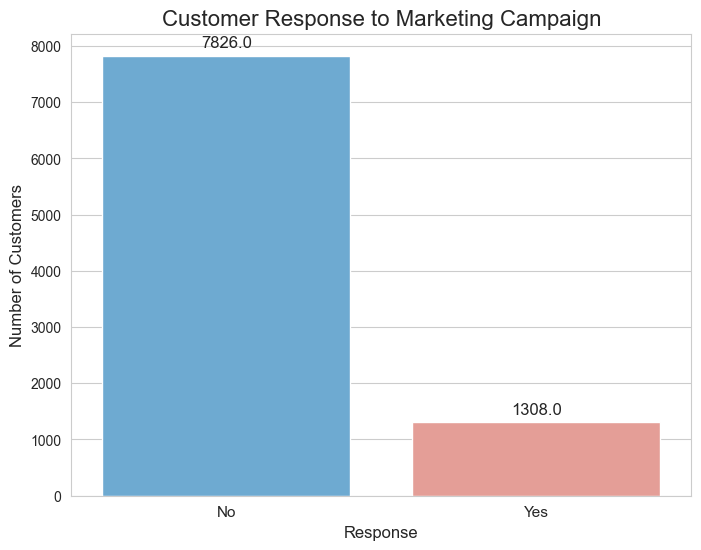

In [12]:
# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Assign the x-variable to 'hue' to use the palette correctly and avoid the warning
ax = sns.countplot(x='response', data=df_clean, hue='response', palette=['#5DADE2', '#F1948A'], legend=False)

# Add titles and labels
plt.title('Customer Response to Marketing Campaign', fontsize=16)
plt.xlabel('Response', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(fontsize=11)

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', fontsize=12)

# Show the plot
plt.show()

## Part B: The Naive Comparison (Correlation is not Causation)

Now that we understand our key variables individually, let's perform the most straightforward comparison: Does the average `total_claim_amount` differ between customers who responded to the campaign and those who didn't?

In [13]:
# Group by the 'response' column and describe the 'total_claim_amount'
naive_comparison = df_clean.groupby('response')['total_claim_amount'].describe()

print("Comparison of Total Claim Amount by Response:")
naive_comparison

Comparison of Total Claim Amount by Response:


,count,mean,std,min,25%,50%,75%,max
response,,,,,,,,
No,7826.0,432.084497,297.815881,0.099007,253.236318,377.083630,550.092193,2893.239678
Yes,1308.0,446.080868,241.906812,7.345946,316.800000,410.120119,547.200000,1358.400000


C:\Users\osipc\AppData\Local\Temp\ipykernel_57408\2049586702.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='response', y='total_claim_amount', data=df_clean, palette=['#5DADE2', '#F1948A'])


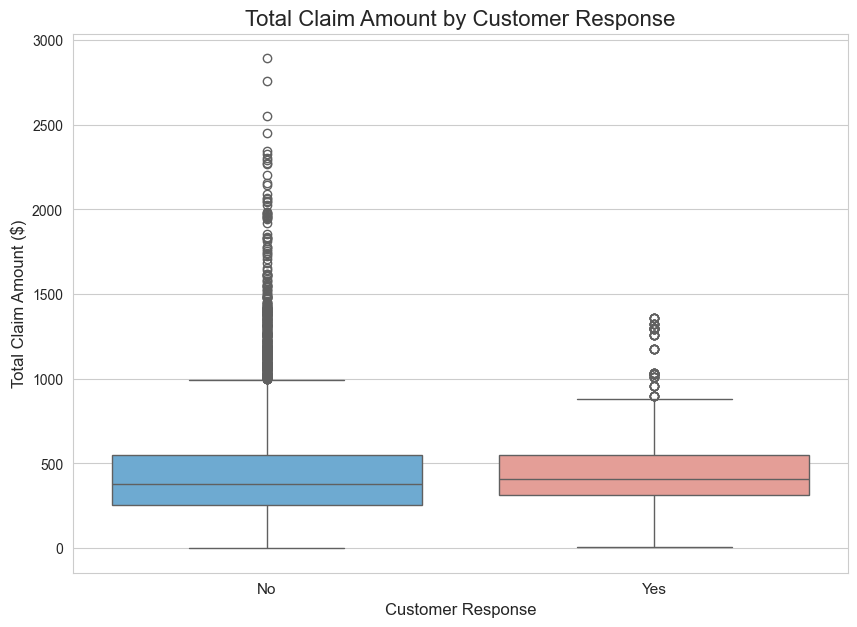

In [ ]:
# Create a figure for the plot
plt.figure(figsize=(10, 7))

# Create a boxplot to compare distributions
sns.boxplot(x='response', y='total_claim_amount', data=df_clean, hue='response', palette=['#5DADE2', '#F1948A'], legend=False)

# Add titles and labels
plt.title('Total Claim Amount by Customer Response', fontsize=16)
plt.xlabel('Customer Response', fontsize=12)
plt.ylabel('Total Claim Amount ($)', fontsize=12)
plt.xticks(fontsize=11)

# Show the plot
plt.show()

# Phase 4: Proving Selection Bias by Analyzing Confounders

Our hypothesis from Phase 3 is that the "naive" comparison of `total_claim_amount` is misleading because of selection bias. We believe the 'Yes' and 'No' groups are fundamentally different.

In this phase, we will prove it. We will compare the distributions of key customer characteristics (potential confounders) between the two groups.

C:\Users\osipc\AppData\Local\Temp\ipykernel_57408\1024379454.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean[df_clean['response'] == 'No']['customer_lifetime_value'], label='Responded - No', shade=True)
C:\Users\osipc\AppData\Local\Temp\ipykernel_57408\1024379454.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean[df_clean['response'] == 'Yes']['customer_lifetime_value'], label='Responded - Yes', shade=True)


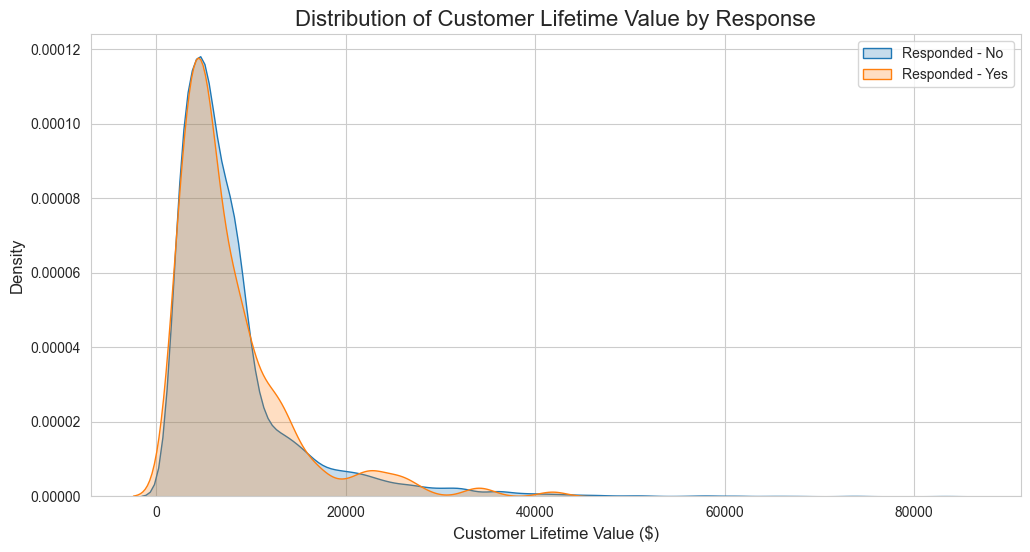

In [15]:
plt.figure(figsize=(12, 6))

# Plot KDE for both groups
sns.kdeplot(df_clean[df_clean['response'] == 'No']['customer_lifetime_value'], label='Responded - No', shade=True)
sns.kdeplot(df_clean[df_clean['response'] == 'Yes']['customer_lifetime_value'], label='Responded - Yes', shade=True)

plt.title('Distribution of Customer Lifetime Value by Response', fontsize=16)
plt.xlabel('Customer Lifetime Value ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

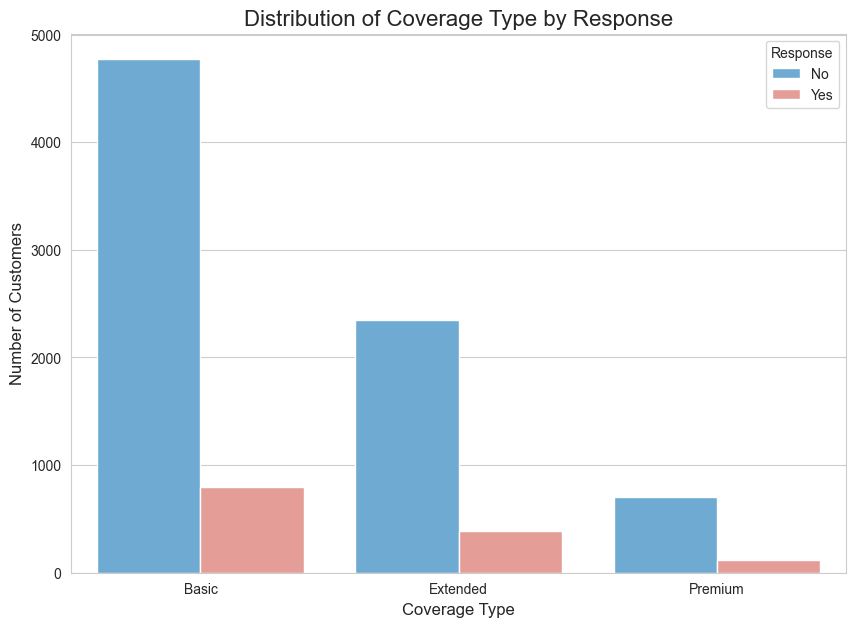

In [16]:
plt.figure(figsize=(10, 7))

# Create a countplot with 'response' as the hue
sns.countplot(x='coverage', hue='response', data=df_clean, palette=['#5DADE2', '#F1948A'])

plt.title('Distribution of Coverage Type by Response', fontsize=16)
plt.xlabel('Coverage Type', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Response')
plt.show()

C:\Users\osipc\AppData\Local\Temp\ipykernel_57408\2423219558.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean[(df_clean['response'] == 'No') & (df_clean['income'] > 0)]['income'], label='Responded - No', shade=True)
C:\Users\osipc\AppData\Local\Temp\ipykernel_57408\2423219558.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean[(df_clean['response'] == 'Yes') & (df_clean['income'] > 0)]['income'], label='Responded - Yes', shade=True)


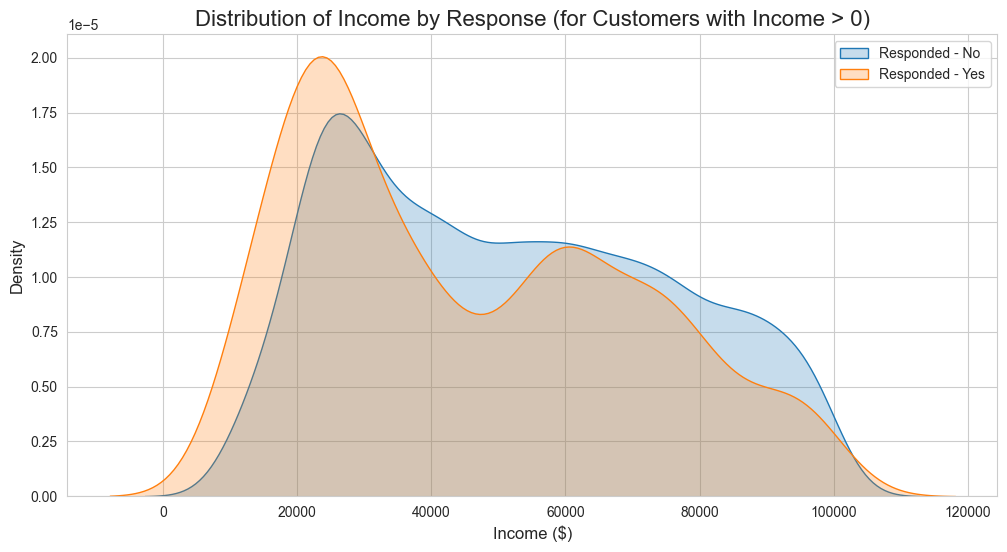

In [17]:
# This will skew the plot. For a clearer view of the employed customers, 
# we can filter out the zeros for this visualization.
plt.figure(figsize=(12, 6))

# Plot KDE for both groups, filtering out those with 0 income for a clearer comparison of employed customers
sns.kdeplot(df_clean[(df_clean['response'] == 'No') & (df_clean['income'] > 0)]['income'], label='Responded - No', shade=True)
sns.kdeplot(df_clean[(df_clean['response'] == 'Yes') & (df_clean['income'] > 0)]['income'], label='Responded - Yes', shade=True)

plt.title('Distribution of Income by Response (for Customers with Income > 0)', fontsize=16)
plt.xlabel('Income ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

## Phase 4 Conclusion: The Evidence for Selection Bias is Clear

Our deep dive into the characteristics of the responding ('Yes') and non-responding ('No') customer groups has confirmed our central hypothesis: **the two groups are not alike.** The evidence of selection bias is clear and compelling, rendering our simple Phase 3 comparison of claim amounts unreliable.

Here is the key evidence we uncovered:

1.  **The Income Disparity (The "Smoking Gun"):** Our most significant finding is the clear difference in income profiles. The analysis shows that customers who responded to the campaign have a demonstrably **lower income distribution** than those who did not. This is a powerful, non-obvious insight. It single-handedly proves we are not comparing two economically similar groups, making a direct comparison of their financial outcomes (like claim amounts) invalid.

2.  **Subtle Differences in Customer Lifetime Value:** While less dramatic than the income disparity, the CLV distributions are also not identical. The group of responders shows a slightly different shape, suggesting that the mix of low, medium, and high-value customers is not the same as in the non-responder group. This adds another layer of evidence that the groups were formed by different underlying factors.

3.  **An Insightful Finding on Coverage:** Interestingly, our analysis revealed that the *rate* of response was relatively consistent across Basic, Extended, and Premium coverage tiers. This is a valuable finding in itself, as it suggests `Coverage` level may not be a primary driver of campaign response. A thorough analysis is not just about finding differences, but also understanding what characteristics *don't* have a strong effect.

### The Verdict

Taken together, this evidence paints an undeniable picture of **selection bias**. The marketing campaign was not responded to by a random cross-section of customers. Instead, the responders represent a specific sub-population with a distinct economic profile.

The small difference in `total_claim_amount` we observed in Phase 3 is now highly suspect. Is the campaign's effect truly negligible? Or is a more significant, real effect being masked or distorted by these profound underlying differences between the groups?

To answer this question and find the true, unconfounded impact of the campaign, we must now move beyond simple comparisons. We are fully justified in employing the tools of causal inference to build a fair, 'apples-to-apples' comparison and isolate the real story.

# Phase 5: Causal Effect Estimation with Propensity Score Matching

Having proven that our treatment and control groups are not comparable, we will now use Propensity Score Matching (PSM) to estimate the true causal effect of the marketing campaign on total claim amounts.

## Part A: Data Preparation for the Propensity Model

In [18]:
# 1. Define a list of our numerical and categorical confounders
numerical_confounders = [
    'customer_lifetime_value',
    'income',
    'monthly_premium_auto',
    'months_since_last_claim',
    'months_since_policy_inception',
    'number_of_open_complaints',
    'number_of_policies',
]

categorical_confounders = [
    'coverage',
    'education',
    'employmentstatus',
    'gender',
    'location_code',
    'marital_status',
    'policy_type',
    'sales_channel',
    'vehicle_class',
    'vehicle_size'
]

# 2. Seperate the numerical and categorical dataframes
X_numerical = df_clean[numerical_confounders]
X_categorical = df_clean[categorical_confounders]

# 3. Scale the numerical features
scaler = StandardScaler()
X_scaled_numerical = scaler.fit_transform(X_numerical)

# Convert the scaled array back to a DataFrame for easy concatenation
X_scaled_numerical_df = pd.DataFrame(X_scaled_numerical, columns=numerical_confounders, index=X_numerical.index)

# 4. One Hot Encode the categorical features
X_encoded_categorical = pd.get_dummies(X_categorical, drop_first=True)

# 5. Combine the scaled numerical and encoded categorical features
X_final = pd.concat([X_scaled_numerical_df, X_encoded_categorical], axis=1)

# 6. Convert the final dataframe to a NumPy array for the model
X_final = X_final.astype(float)
X = X_final.values

# Final data
Y = df_clean['total_claim_amount'].values
D = df_clean['treatment'].values

print("Shape of our final confounder matrix:", X.shape)
print("Data preparation with scaling is complete.")

X_final.head()

Shape of our final confounder matrix: (9134, 34)
Data preparation with scaling is complete.


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,education_Master,employmentstatus_Employed,employmentstatus_Medical Leave,employmentstatus_Retired,employmentstatus_Unemployed,gender_M,location_code_Suburban,location_code_Urban,marital_status_Married,marital_status_Single,policy_type_Personal Auto,policy_type_Special Auto,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,-0.762878,0.612827,-0.703925,1.678099,-1.543287,-0.42225,-0.822648,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.149245,-1.239617,0.022691,-0.208186,-0.217334,-0.42225,2.106160,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.710636,0.365710,0.429596,0.288205,-0.360680,-0.42225,-0.404247,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.052263,-1.239617,0.371467,0.288205,0.606907,-0.42225,1.687759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.755575,0.203390,-0.587666,-0.307465,-0.145661,-0.42225,-0.822648,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
# Initialize the CausalModel
causal = CausalModel(Y, D, X)

# Print the summary statistics
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=7826)        Treated (N_t=1308)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y      432.084      297.816      446.081      241.907       13.996

                      Controls (N_c=7826)        Treated (N_t=1308)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.004        1.014       -0.022        0.910       -0.026
             X1       -0.005        1.012        0.029        0.923        0.035
             X2       -0.004        0.991        0.027        1.055        0.031
             X3        0.007        1.005       -0.041        0.970       -0.048
             X4       -0.001        1.005        0.007        0.970        0.009
      

In [20]:
causal.est_propensity()

print("Propensity scores estimated successfully.")
print("First 5 scores:", causal.propensity['fitted'][:5])

Propensity scores estimated successfully.
First 5 scores: [0.24919184 0.098747   0.2355312  0.08085717 0.09024913]


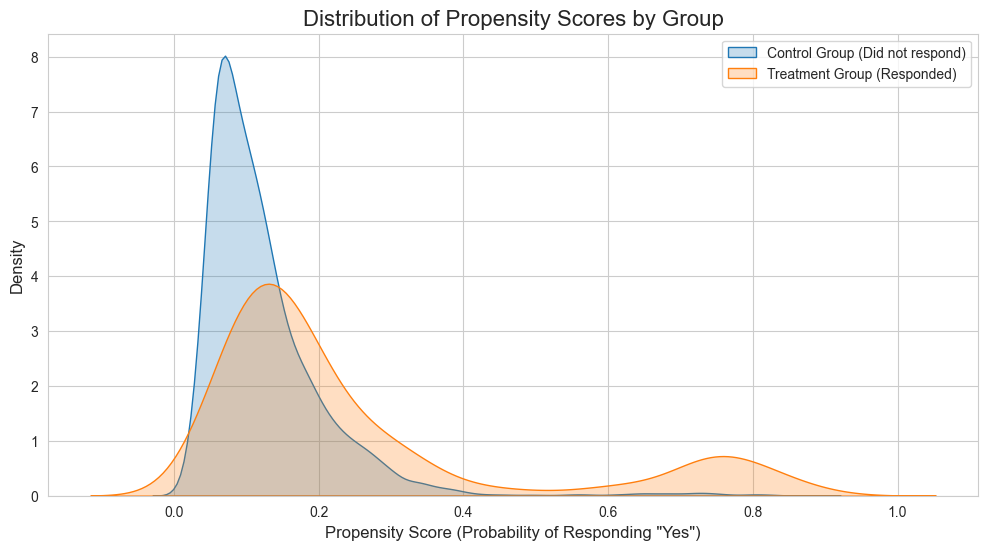

In [21]:
propensity_scores = causal.propensity['fitted']

# Now that propensity_scores is a NumPy array, we can use boolean indexing.
ps_treatment = propensity_scores[D == 1]
ps_control = propensity_scores[D == 0]

# Plot the distributions
plt.figure(figsize=(12, 6))
# The 'shade' parameter is deprecated, using 'fill' instead for modern seaborn versions
sns.kdeplot(ps_control, label='Control Group (Did not respond)', fill=True)
sns.kdeplot(ps_treatment, label='Treatment Group (Responded)', fill=True)

plt.title('Distribution of Propensity Scores by Group', fontsize=16)
plt.xlabel('Propensity Score (Probability of Responding "Yes")', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

In [22]:
# Estimate the causal effect using propensity score matching.
causal.est_via_matching(matches=1, bias_adj=True)

# Display the final estimates
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    -20.230      6.264     -3.230      0.001    -32.507     -7.954
           ATC    -22.804      6.435     -3.544      0.000    -35.417    -10.191
           ATT     -4.833     12.608     -0.383      0.701    -29.544     19.878



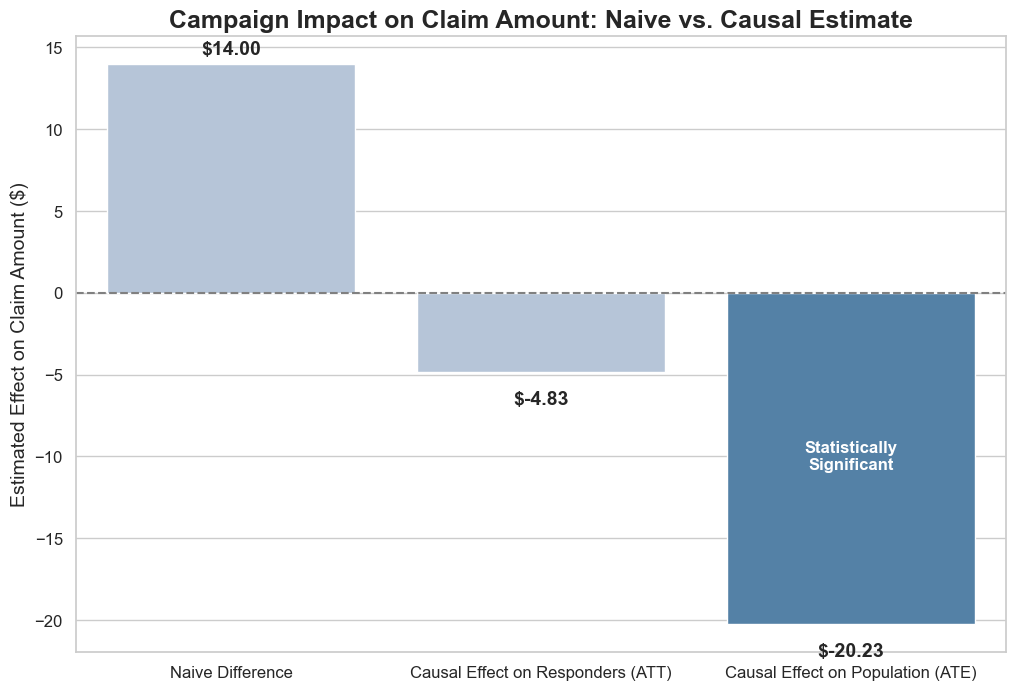

In [23]:
# Data from Your Results
data = {
    'Metric': ['Naive Difference', 'Causal Effect on Responders (ATT)', 'Causal Effect on Population (ATE)'],
    'Estimate': [14.00, -4.83, -20.23],
    'Significant': [False, False, True]
}
results_df = pd.DataFrame(data)

# Create the Chart
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Color Palette
palette = {True: '#4682B4', False: '#B0C4DE'} 

# Create the bar plot
ax = sns.barplot(
    x='Metric',
    y='Estimate',
    data=results_df,
    hue='Significant', 
    palette=palette,
    dodge=False,
    legend=False 
)

#  Add Annotations and Labels for Clarity 
# Add a horizontal line at y=0 for reference
ax.axhline(0, color='grey', linestyle='--')

# Add the value labels on top of each bar
for p in ax.patches:
    ax.annotate(f"${p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10 if p.get_height() > 0 else -20),
                textcoords = 'offset points',
                fontsize=14,
                weight='bold')

# Add significance text inside the most important bar
ax.text(2, -10, 'Statistically\nSignificant', # Position for the ATE bar
        ha='center', va='center', color='white', fontsize=12, weight='bold')


# Set titles and labels
plt.title('Campaign Impact on Claim Amount: Naive vs. Causal Estimate', fontsize=18, weight='bold')
plt.ylabel('Estimated Effect on Claim Amount ($)', fontsize=14)
plt.xlabel('') 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()